In [1]:
!pip install --upgrade "numpy<2"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pwd

/content


In [2]:
ls

sample_data/


In [5]:
cd drive/MyDrive/Projects/rl

/content/drive/MyDrive/Projects/rl


In [6]:
# !git clone https://github.com/sainijagjit/DDPG-Pytorch.git

In [7]:
cd DDPG-Pytorch/

/content/drive/MyDrive/Projects/rl/DDPG-Pytorch


In [8]:
# !apt-get install -y swig
!pip install gym==0.26.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827728 sha256=3bf7e82e64b16244d009ab4a338dfe9fa81735ffa8b994c18f488a458019f571
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
from environment import PointParticleEnv

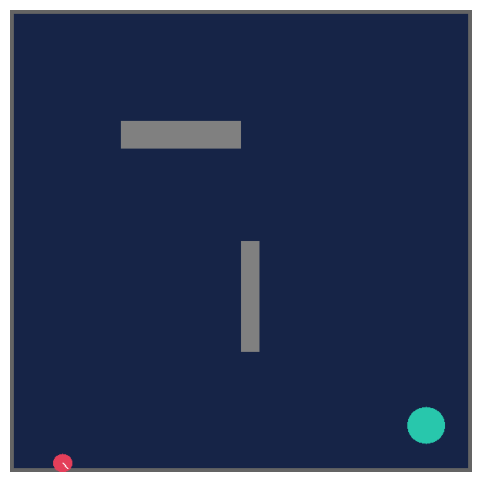

In [12]:
# Create environment with obstacles in state

env = PointParticleEnv()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def run_random_agent_animation(env, steps=500):
    frames = []
    state = env.reset()
    for _ in range(steps):
        # Sample a random action from the continuous action space
        action = env.action_space.sample()
        state, reward, done,_,info = env.step(action)
        frame = env.render(mode='rgb_array')
        frames.append(frame)
        if done:
            break
    return frames

# Create environment instance (with obstacles and continuous actions)
env = PointParticleEnv(obs=True)

# Run the agent for 50 random steps and collect frames
frames = run_random_agent_animation(env, steps=150)

# Create animation using matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
im = ax.imshow(frames[0])

def update(frame):
    im.set_data(frame)
    return [im]

anim = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=True)

# Display animation as HTML video (for Jupyter notebooks)
HTML(anim.to_html5_video())



In [18]:
import os
import wandb
import csv
# import gym
import json
import torch
import numpy as np
from tqdm import tqdm
from src.utils import *
from src.memory import *
from src.agents import *
from datetime import datetime

os.environ['WANDB_API_KEY'] = ''
class Trainer:

    def __init__(self, config_file, enable_logging=True):
        self.enable_logging = enable_logging
        self.config = Trainer.parse_config(config_file)
        self.env =  gym.make(self.config['env_name'])
        self.env = apply_seed(self.env,self.config['seed'])
        self.state_dimension = self.env.observation_space.shape[0]
        print("state",self.state_dimension)
        self.action_dimension = self.env.action_space.shape[0]
        print("action",self.action_dimension)
        self.max_action = float(self.env.action_space.high[0])
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.agent = DDPGAgent(
            state_dim=self.state_dimension, action_dim=self.action_dimension,
            max_action=self.max_action, device=self.device,
            discount=self.config['discount'], tau=self.config['tau']
        )
        self.save_file_name = f"DDPG_{self.config['env_name']}_{self.config['seed']}"
        self.memory = ReplayBuffer()
        if self.enable_logging:
            wandb.init(project="ddpg", config=self.config)
        try:
            os.mkdir('./pretrained_models')
        except Exception as e:
            pass



        # CSV logging setup

        # 1) Build a timestamped run directory
        run_id = datetime.now().strftime("%Y_%m%_d_%H%M%S")
        self.log_dir = os.path.join(os.getcwd(), f"logs_{run_id}")
        os.makedirs(self.log_dir, exist_ok=True)

        # 2) Open your CSVs inside that folder
        csv1_path = os.path.join(self.log_dir, "csv1.csv")
        csv2_path = os.path.join(self.log_dir, "csv2.csv")
        # Use buffering=1 (line‐buffered) so each writer.writerow() flushes automatically
        self.csv1_file = open(csv1_path, 'w', newline='', buffering=1)
        self.csv2_file = open(csv2_path, 'w', newline='', buffering=1)

        # self.csv1_file = open('csv1.csv', 'w', newline='')
        # self.csv2_file = open('csv2.csv', 'w', newline='')
        self.csv1_writer = csv.writer(self.csv1_file)
        self.csv2_writer = csv.writer(self.csv2_file)
        # write headers
        self.csv1_writer.writerow(['episode', 'episode_reward', 'goal_reached', 'reason', 'max_steps'])
        self.csv2_writer.writerow(['episode', 'step', 'observation', 'reward'])

        # if self.enable_logging:
        #     wandb.init(project="ddpg", config=self.config)
        try:
            os.mkdir('./pretrained_models')
        except Exception:
            pass




    @staticmethod
    def parse_config(json_file):
        with open(json_file, 'r') as f:
            configs = json.load(f)
        return configs
    def train(self):
        num_episodes = 500
        max_episode_steps = int(self.config.get('max_episode_steps', self.env._max_episode_steps))

        ts = 0  # global time-step counter
        episode_rewards = []
        evaluations = []

        for ep in tqdm(range(1, num_episodes + 1)):
            print("episode number is: ", ep)
            state, info = self.env.reset()
            episode_reward, episode_timesteps = 0, 0
            done = False

            # run one episode
            while not done and episode_timesteps < max_episode_steps:
                episode_timesteps += 1
                ts += 1

                # select action
                if ts < self.config['start_time_step']:
                    action = self.env.action_space.sample()
                else:
                    action = (
                        self.agent.select_action(np.array(state))
                        + np.random.normal(0, self.max_action * self.config['expl_noise'], size=self.action_dimension)
                    ).clip(-self.max_action, self.max_action)

                # step the env
                next_state, reward, done, trunc, info = self.env.step(action)

                # log step-level data
                self.csv2_writer.writerow([ep, episode_timesteps, json.dumps(next_state.tolist()), reward])

                # push into replay, using 0-mask if time limit reached
                time_limit_reached = (episode_timesteps >= max_episode_steps)
                mask = float(done) if not time_limit_reached else 0.0
                self.memory.push(state, action, reward, next_state, mask)

                state = next_state
                episode_reward += reward

                # train after warm-up
                if ts >= self.config['start_time_step']:
                    self.agent.train(self.memory, self.config['batch_size'])

            # end of episode: summary logging
            # wandb.log({'Episode': ep,
            #           'Episode Reward': episode_reward,
            #           'Episode Length': episode_timesteps,
            #           'Global Step': ts})
            if done and not time_limit_reached:
                goal_reached = 1
                reason = 'goal reached'
            else:
                goal_reached = 0
                reason = 'max step reached'
            self.csv1_writer.writerow([ep, episode_reward, goal_reached, reason, episode_timesteps])

            episode_rewards.append(episode_reward)

            # every 10 episodes, evaluate + checkpoint
            if ep % 10 == 0:
                eval_score = evaluate_policy(
                    self.agent,
                    self.config['env_name'],
                    self.config['seed'],
                    enable_logging=False,
                    wandb=None
                )
                evaluations.append(eval_score)
                self.agent.save_checkpoint(f"./pretrained_models/{self.save_file_name}")

        # wandb.finish()
        # close CSV files
        self.csv1_file.close()
        self.csv2_file.close()
        return episode_rewards, evaluations



    def evaluate(self):
        self.agent.load_checkpoint(f"./pretrained_models/DDPG_{self.config['env_name']}_{self.config['seed']}")
        evaluate_policy(self.agent, self.config['env_name'], self.config['seed'],render=True)

state 3
action 1


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment PointParticle-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 1/500 [00:00<01:17,  6.48it/s]

episode number is:  1
episode number is:  2


  1%|          | 3/500 [00:00<01:16,  6.46it/s]

episode number is:  3
episode number is:  4


  1%|          | 5/500 [00:00<01:26,  5.75it/s]

episode number is:  5
episode number is:  6


  1%|▏         | 7/500 [00:01<01:27,  5.63it/s]

episode number is:  7
episode number is:  8


  2%|▏         | 9/500 [00:01<01:24,  5.83it/s]

episode number is:  9
episode number is:  10
Episode reward 1 ==> -31601.85939689448
Episode reward 2 ==> -31601.85939689448
Episode reward 3 ==> -31601.85939689448
Episode reward 4 ==> -31601.85939689448
Episode reward 5 ==> -31601.85939689448
Episode reward 6 ==> -31601.85939689448
Episode reward 7 ==> -31601.85939689448
Episode reward 8 ==> -31601.85939689448
Episode reward 9 ==> -31601.85939689448
Episode reward 10 ==> -31601.85939689448
avg_reward -31601.859396893626


  2%|▏         | 11/500 [00:09<15:15,  1.87s/it]

episode number is:  11
episode number is:  12


  3%|▎         | 13/500 [00:10<08:04,  1.01it/s]

episode number is:  13
episode number is:  14


  3%|▎         | 15/500 [00:10<04:38,  1.74it/s]

episode number is:  15
episode number is:  16


  3%|▎         | 17/500 [00:10<02:57,  2.72it/s]

episode number is:  17
episode number is:  18


  4%|▍         | 19/500 [00:11<02:08,  3.74it/s]

episode number is:  19
episode number is:  20
Episode reward 1 ==> -31601.85939689448
Episode reward 2 ==> -31601.85939689448
Episode reward 3 ==> -31601.85939689448
Episode reward 4 ==> -31601.85939689448
Episode reward 5 ==> -31601.85939689448
Episode reward 6 ==> -31601.85939689448
Episode reward 7 ==> -31601.85939689448
Episode reward 8 ==> -31601.85939689448
Episode reward 9 ==> -31601.85939689448


  4%|▍         | 20/500 [00:13<07:12,  1.11it/s]

Episode reward 10 ==> -31601.85939689448
avg_reward -31601.859396893626
episode number is:  21


  4%|▍         | 22/500 [00:13<04:07,  1.93it/s]

episode number is:  22
episode number is:  23


  5%|▍         | 24/500 [00:14<02:39,  2.98it/s]

episode number is:  24
episode number is:  25


  5%|▌         | 26/500 [00:14<01:56,  4.08it/s]

episode number is:  26
episode number is:  27


  6%|▌         | 28/500 [00:14<01:34,  4.98it/s]

episode number is:  28
episode number is:  29


  6%|▌         | 29/500 [00:14<01:31,  5.17it/s]

episode number is:  30
Episode reward 1 ==> -31601.85939689448
Episode reward 2 ==> -31601.85939689448
Episode reward 3 ==> -31601.85939689448
Episode reward 4 ==> -31601.85939689448
Episode reward 5 ==> -31601.85939689448
Episode reward 6 ==> -31601.85939689448
Episode reward 7 ==> -31601.85939689448
Episode reward 8 ==> -31601.85939689448
Episode reward 9 ==> -31601.85939689448


  6%|▌         | 30/500 [00:18<08:43,  1.11s/it]

Episode reward 10 ==> -31601.85939689448
avg_reward -31601.859396893626
episode number is:  31


  6%|▋         | 32/500 [00:18<04:52,  1.60it/s]

episode number is:  32
episode number is:  33


  7%|▋         | 34/500 [00:18<03:04,  2.53it/s]

episode number is:  34
episode number is:  35


  7%|▋         | 36/500 [00:19<02:09,  3.59it/s]

episode number is:  36
episode number is:  37


  8%|▊         | 38/500 [00:19<01:47,  4.31it/s]

episode number is:  38
episode number is:  39


  8%|▊         | 39/500 [00:19<01:38,  4.70it/s]

episode number is:  40
Episode reward 1 ==> -31601.85939689448
Episode reward 2 ==> -31601.85939689448
Episode reward 3 ==> -31601.85939689448
Episode reward 4 ==> -31601.85939689448
Episode reward 5 ==> -31601.85939689448
Episode reward 6 ==> -31601.85939689448
Episode reward 7 ==> -31601.85939689448
Episode reward 8 ==> -31601.85939689448
Episode reward 9 ==> -31601.85939689448


  8%|▊         | 41/500 [00:22<05:11,  1.47it/s]

Episode reward 10 ==> -31601.85939689448
avg_reward -31601.859396893626
episode number is:  41
episode number is:  42


  9%|▊         | 43/500 [00:22<03:09,  2.41it/s]

episode number is:  43
episode number is:  44


  9%|▉         | 45/500 [00:23<02:09,  3.52it/s]

episode number is:  45
episode number is:  46


  9%|▉         | 47/500 [00:23<01:38,  4.60it/s]

episode number is:  47
episode number is:  48


 10%|▉         | 49/500 [00:23<01:22,  5.46it/s]

episode number is:  49
episode number is:  50
Episode reward 1 ==> -31601.85939689448
Episode reward 2 ==> -31601.85939689448
Episode reward 3 ==> -31601.85939689448
Episode reward 4 ==> -31601.85939689448
Episode reward 5 ==> -31601.85939689448
Episode reward 6 ==> -31601.85939689448
Episode reward 7 ==> -31601.85939689448
Episode reward 8 ==> -31601.85939689448
Episode reward 9 ==> -31601.85939689448


 10%|█         | 50/500 [00:25<06:06,  1.23it/s]

Episode reward 10 ==> -31601.85939689448
avg_reward -31601.859396893626
episode number is:  51


 10%|█         | 52/500 [00:26<03:34,  2.08it/s]

episode number is:  52
episode number is:  53


 11%|█         | 54/500 [00:26<02:20,  3.16it/s]

episode number is:  54
episode number is:  55


 11%|█         | 56/500 [00:26<01:43,  4.29it/s]

episode number is:  56
episode number is:  57


 12%|█▏        | 58/500 [00:27<01:26,  5.12it/s]

episode number is:  58
episode number is:  59


 12%|█▏        | 59/500 [00:27<01:25,  5.15it/s]

episode number is:  60
Episode reward 1 ==> -31601.85939689448
Episode reward 2 ==> -31601.85939689448
Episode reward 3 ==> -31601.85939689448
Episode reward 4 ==> -31601.85939689448
Episode reward 5 ==> -31601.85939689448
Episode reward 6 ==> -31601.85939689448
Episode reward 7 ==> -31601.85939689448
Episode reward 8 ==> -31601.85939689448
Episode reward 9 ==> -31601.85939689448
Episode reward 10 ==> -31601.85939689448
avg_reward -31601.859396893626


 12%|█▏        | 61/500 [00:29<04:30,  1.62it/s]

episode number is:  61
episode number is:  62


 13%|█▎        | 63/500 [00:30<02:44,  2.65it/s]

episode number is:  63
episode number is:  64


 13%|█▎        | 65/500 [00:30<01:56,  3.74it/s]

episode number is:  65
episode number is:  66


 13%|█▎        | 67/500 [00:30<01:37,  4.44it/s]

episode number is:  67
episode number is:  68


 14%|█▍        | 69/500 [00:31<01:24,  5.09it/s]

episode number is:  69
episode number is:  70
Episode reward 1 ==> -31601.85939689448
Episode reward 2 ==> -31601.85939689448
Episode reward 3 ==> -31601.85939689448
Episode reward 4 ==> -31601.85939689448
Episode reward 5 ==> -31601.85939689448
Episode reward 6 ==> -31601.85939689448
Episode reward 7 ==> -31601.85939689448
Episode reward 8 ==> -31601.85939689448
Episode reward 9 ==> -31601.85939689448


 14%|█▍        | 70/500 [00:34<07:50,  1.09s/it]

Episode reward 10 ==> -31601.85939689448
avg_reward -31601.859396893626
episode number is:  71


 14%|█▍        | 72/500 [00:34<04:29,  1.59it/s]

episode number is:  72
episode number is:  73


 15%|█▍        | 74/500 [00:35<02:52,  2.47it/s]

episode number is:  74
episode number is:  75


 15%|█▌        | 76/500 [00:35<02:04,  3.41it/s]

episode number is:  76
episode number is:  77


 16%|█▌        | 79/500 [00:35<01:14,  5.65it/s]

episode number is:  78
episode number is:  79
episode number is:  80
Episode reward 1 ==> -31601.85939689448
Episode reward 2 ==> -31601.85939689448
Episode reward 3 ==> -31601.85939689448
Episode reward 4 ==> -31601.85939689448
Episode reward 5 ==> -31601.85939689448
Episode reward 6 ==> -31601.85939689448
Episode reward 7 ==> -31601.85939689448
Episode reward 8 ==> -31601.85939689448
Episode reward 9 ==> -31601.85939689448


 16%|█▌        | 80/500 [00:38<06:06,  1.15it/s]

Episode reward 10 ==> -31601.85939689448
avg_reward -31601.859396893626
episode number is:  81


 16%|█▋        | 82/500 [00:39<03:45,  1.85it/s]

episode number is:  82
episode number is:  83


 17%|█▋        | 84/500 [00:39<02:24,  2.89it/s]

episode number is:  84
episode number is:  85


 17%|█▋        | 85/500 [00:40<04:33,  1.52it/s]

episode number is:  86


 17%|█▋        | 86/500 [00:42<06:00,  1.15it/s]

episode number is:  87


 17%|█▋        | 87/500 [00:43<07:03,  1.02s/it]

episode number is:  88


 18%|█▊        | 88/500 [00:44<07:38,  1.11s/it]

episode number is:  89


 18%|█▊        | 89/500 [00:46<08:47,  1.28s/it]

episode number is:  90
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277


 18%|█▊        | 90/500 [00:48<10:38,  1.56s/it]

Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  91


 18%|█▊        | 91/500 [00:50<11:40,  1.71s/it]

episode number is:  92


 18%|█▊        | 92/500 [00:52<10:55,  1.61s/it]

episode number is:  93


 19%|█▊        | 93/500 [00:53<10:15,  1.51s/it]

episode number is:  94


 19%|█▉        | 94/500 [00:54<09:52,  1.46s/it]

episode number is:  95


 19%|█▉        | 95/500 [00:56<09:39,  1.43s/it]

episode number is:  96


 19%|█▉        | 96/500 [00:57<08:53,  1.32s/it]

episode number is:  97


 19%|█▉        | 97/500 [00:58<09:04,  1.35s/it]

episode number is:  98


 20%|█▉        | 98/500 [01:00<09:46,  1.46s/it]

episode number is:  99


 20%|█▉        | 99/500 [01:02<10:41,  1.60s/it]

episode number is:  100
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277


 20%|██        | 100/500 [01:05<13:06,  1.97s/it]

Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  101


 20%|██        | 101/500 [01:07<12:53,  1.94s/it]

episode number is:  102


 20%|██        | 102/500 [01:08<12:02,  1.82s/it]

episode number is:  103


 21%|██        | 103/500 [01:10<11:21,  1.72s/it]

episode number is:  104


 21%|██        | 104/500 [01:11<10:50,  1.64s/it]

episode number is:  105


 21%|██        | 105/500 [01:13<10:32,  1.60s/it]

episode number is:  106


 21%|██        | 106/500 [01:14<09:40,  1.47s/it]

episode number is:  107


 21%|██▏       | 107/500 [01:15<09:48,  1.50s/it]

episode number is:  108


 22%|██▏       | 108/500 [01:18<11:57,  1.83s/it]

episode number is:  109


 22%|██▏       | 109/500 [01:20<12:33,  1.93s/it]

episode number is:  110
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 22%|██▏       | 110/500 [01:22<12:52,  1.98s/it]

episode number is:  111


 22%|██▏       | 111/500 [01:24<11:59,  1.85s/it]

episode number is:  112


 22%|██▏       | 112/500 [01:25<11:16,  1.74s/it]

episode number is:  113


 23%|██▎       | 113/500 [01:27<11:33,  1.79s/it]

episode number is:  114


 23%|██▎       | 114/500 [01:29<10:56,  1.70s/it]

episode number is:  115


 23%|██▎       | 115/500 [01:30<10:32,  1.64s/it]

episode number is:  116


 23%|██▎       | 116/500 [01:32<10:15,  1.60s/it]

episode number is:  117


 23%|██▎       | 117/500 [01:34<11:35,  1.82s/it]

episode number is:  118


 24%|██▎       | 118/500 [01:37<13:34,  2.13s/it]

episode number is:  119


 24%|██▍       | 119/500 [01:38<12:20,  1.94s/it]

episode number is:  120
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 24%|██▍       | 120/500 [01:40<12:28,  1.97s/it]

episode number is:  121


 24%|██▍       | 121/500 [01:42<11:43,  1.86s/it]

episode number is:  122


 24%|██▍       | 122/500 [01:43<10:58,  1.74s/it]

episode number is:  123


 25%|██▍       | 123/500 [01:45<10:24,  1.66s/it]

episode number is:  124


 25%|██▍       | 124/500 [01:47<10:36,  1.69s/it]

episode number is:  125


 25%|██▌       | 125/500 [01:49<11:33,  1.85s/it]

episode number is:  126


 25%|██▌       | 126/500 [01:51<11:17,  1.81s/it]

episode number is:  127


 25%|██▌       | 127/500 [01:52<11:00,  1.77s/it]

episode number is:  128


 26%|██▌       | 128/500 [01:54<11:01,  1.78s/it]

episode number is:  129


 26%|██▌       | 129/500 [01:56<10:30,  1.70s/it]

episode number is:  130
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277


 26%|██▌       | 130/500 [01:58<11:00,  1.79s/it]

Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  131


 26%|██▌       | 131/500 [01:59<11:09,  1.82s/it]

episode number is:  132


 26%|██▋       | 132/500 [02:01<11:29,  1.87s/it]

episode number is:  133


 27%|██▋       | 133/500 [02:05<14:10,  2.32s/it]

episode number is:  134


 27%|██▋       | 134/500 [02:07<14:33,  2.39s/it]

episode number is:  135


 27%|██▋       | 135/500 [02:09<13:34,  2.23s/it]

episode number is:  136


 27%|██▋       | 136/500 [02:10<11:39,  1.92s/it]

episode number is:  137


 27%|██▋       | 137/500 [02:12<11:03,  1.83s/it]

episode number is:  138


 28%|██▊       | 138/500 [02:14<10:57,  1.82s/it]

episode number is:  139


 28%|██▊       | 139/500 [02:15<10:21,  1.72s/it]

episode number is:  140
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 28%|██▊       | 140/500 [02:17<10:54,  1.82s/it]

episode number is:  141


 28%|██▊       | 141/500 [02:19<10:54,  1.82s/it]

episode number is:  142


 28%|██▊       | 142/500 [02:21<11:30,  1.93s/it]

episode number is:  143


 29%|██▊       | 143/500 [02:24<11:51,  1.99s/it]

episode number is:  144


 29%|██▉       | 144/500 [02:25<11:04,  1.87s/it]

episode number is:  145


 29%|██▉       | 145/500 [02:27<10:25,  1.76s/it]

episode number is:  146


 29%|██▉       | 146/500 [02:28<09:20,  1.58s/it]

episode number is:  147


 29%|██▉       | 147/500 [02:29<09:21,  1.59s/it]

episode number is:  148


 30%|██▉       | 148/500 [02:31<09:44,  1.66s/it]

episode number is:  149


 30%|██▉       | 149/500 [02:33<09:25,  1.61s/it]

episode number is:  150
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277


 30%|███       | 150/500 [02:35<10:44,  1.84s/it]

Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  151


 30%|███       | 151/500 [02:37<11:30,  1.98s/it]

episode number is:  152


 30%|███       | 152/500 [02:39<11:23,  1.96s/it]

episode number is:  153


 31%|███       | 153/500 [02:41<10:32,  1.82s/it]

episode number is:  154


 31%|███       | 154/500 [02:42<09:56,  1.72s/it]

episode number is:  155


 31%|███       | 155/500 [02:44<09:34,  1.66s/it]

episode number is:  156


 31%|███       | 156/500 [02:45<08:43,  1.52s/it]

episode number is:  157


 31%|███▏      | 157/500 [02:47<08:53,  1.56s/it]

episode number is:  158


 32%|███▏      | 158/500 [02:48<09:22,  1.64s/it]

episode number is:  159


 32%|███▏      | 159/500 [02:51<10:03,  1.77s/it]

episode number is:  160
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277


 32%|███▏      | 160/500 [02:53<11:47,  2.08s/it]

Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  161


 32%|███▏      | 161/500 [02:55<11:16,  2.00s/it]

episode number is:  162


 32%|███▏      | 162/500 [02:57<10:26,  1.85s/it]

episode number is:  163


 33%|███▎      | 163/500 [02:58<09:48,  1.75s/it]

episode number is:  164


 33%|███▎      | 164/500 [03:00<09:23,  1.68s/it]

episode number is:  165


 33%|███▎      | 165/500 [03:01<09:05,  1.63s/it]

episode number is:  166


 33%|███▎      | 166/500 [03:02<08:18,  1.49s/it]

episode number is:  167


 33%|███▎      | 167/500 [03:04<08:31,  1.54s/it]

episode number is:  168


 34%|███▎      | 168/500 [03:07<10:17,  1.86s/it]

episode number is:  169


 34%|███▍      | 169/500 [03:09<10:47,  1.96s/it]

episode number is:  170
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 34%|███▍      | 170/500 [03:11<10:57,  1.99s/it]

episode number is:  171


 34%|███▍      | 171/500 [03:13<10:18,  1.88s/it]

episode number is:  172


 34%|███▍      | 172/500 [03:14<09:38,  1.76s/it]

episode number is:  173


 35%|███▍      | 173/500 [03:15<09:08,  1.68s/it]

episode number is:  174


 35%|███▍      | 174/500 [03:17<08:50,  1.63s/it]

episode number is:  175


 35%|███▌      | 175/500 [03:18<08:38,  1.59s/it]

episode number is:  176


 35%|███▌      | 176/500 [03:20<08:26,  1.56s/it]

episode number is:  177


 35%|███▌      | 177/500 [03:22<09:41,  1.80s/it]

episode number is:  178


 36%|███▌      | 178/500 [03:25<10:34,  1.97s/it]

episode number is:  179


 36%|███▌      | 179/500 [03:26<09:45,  1.82s/it]

episode number is:  180
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277


 36%|███▌      | 180/500 [03:28<09:55,  1.86s/it]

Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  181


 36%|███▌      | 181/500 [03:30<09:28,  1.78s/it]

episode number is:  182


 36%|███▋      | 182/500 [03:31<08:59,  1.70s/it]

episode number is:  183


 37%|███▋      | 183/500 [03:33<08:41,  1.65s/it]

episode number is:  184


 37%|███▋      | 184/500 [03:34<08:35,  1.63s/it]

episode number is:  185


 37%|███▋      | 185/500 [03:37<09:28,  1.81s/it]

episode number is:  186


 37%|███▋      | 186/500 [03:38<09:19,  1.78s/it]

episode number is:  187


 37%|███▋      | 187/500 [03:40<09:27,  1.81s/it]

episode number is:  188


 38%|███▊      | 188/500 [03:42<09:25,  1.81s/it]

episode number is:  189


 38%|███▊      | 189/500 [03:43<08:54,  1.72s/it]

episode number is:  190
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277


 38%|███▊      | 190/500 [03:45<09:15,  1.79s/it]

Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  191


 38%|███▊      | 191/500 [03:47<09:00,  1.75s/it]

episode number is:  192


 38%|███▊      | 192/500 [03:49<08:39,  1.69s/it]

episode number is:  193


 39%|███▊      | 193/500 [03:51<08:58,  1.76s/it]

episode number is:  194


 39%|███▉      | 194/500 [03:53<09:36,  1.89s/it]

episode number is:  195


 39%|███▉      | 195/500 [03:55<09:50,  1.93s/it]

episode number is:  196


 39%|███▉      | 196/500 [03:56<08:41,  1.72s/it]

episode number is:  197


 39%|███▉      | 197/500 [03:58<08:30,  1.68s/it]

episode number is:  198


 40%|███▉      | 198/500 [03:59<08:42,  1.73s/it]

episode number is:  199


 40%|███▉      | 199/500 [04:01<08:19,  1.66s/it]

episode number is:  200
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277


 40%|████      | 200/500 [04:03<08:47,  1.76s/it]

Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  201


 40%|████      | 201/500 [04:05<08:43,  1.75s/it]

episode number is:  202


 40%|████      | 202/500 [04:07<09:21,  1.88s/it]

episode number is:  203


 41%|████      | 203/500 [04:09<09:41,  1.96s/it]

episode number is:  204


 41%|████      | 204/500 [04:11<09:14,  1.87s/it]

episode number is:  205


 41%|████      | 205/500 [04:12<08:41,  1.77s/it]

episode number is:  206


 41%|████      | 206/500 [04:13<07:49,  1.60s/it]

episode number is:  207


 41%|████▏     | 207/500 [04:15<07:49,  1.60s/it]

episode number is:  208


 42%|████▏     | 208/500 [04:17<08:06,  1.66s/it]

episode number is:  209


 42%|████▏     | 209/500 [04:18<07:54,  1.63s/it]

episode number is:  210
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277


 42%|████▏     | 210/500 [04:21<08:58,  1.86s/it]

Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  211


 42%|████▏     | 211/500 [04:23<09:37,  2.00s/it]

episode number is:  212


 42%|████▏     | 212/500 [04:25<09:38,  2.01s/it]

episode number is:  213


 43%|████▎     | 213/500 [04:27<08:50,  1.85s/it]

episode number is:  214


 43%|████▎     | 214/500 [04:28<08:18,  1.74s/it]

episode number is:  215


 43%|████▎     | 215/500 [04:30<07:58,  1.68s/it]

episode number is:  216


 43%|████▎     | 216/500 [04:31<07:15,  1.53s/it]

episode number is:  217


 43%|████▎     | 217/500 [04:32<07:23,  1.57s/it]

episode number is:  218


 44%|████▎     | 218/500 [04:34<07:43,  1.64s/it]

episode number is:  219


 44%|████▍     | 219/500 [04:36<08:16,  1.77s/it]

episode number is:  220
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277


 44%|████▍     | 220/500 [04:39<09:43,  2.08s/it]

Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  221


 44%|████▍     | 221/500 [04:41<09:18,  2.00s/it]

episode number is:  222


 44%|████▍     | 222/500 [04:42<08:36,  1.86s/it]

episode number is:  223


 45%|████▍     | 223/500 [04:44<08:03,  1.74s/it]

episode number is:  224


 45%|████▍     | 224/500 [04:45<07:41,  1.67s/it]

episode number is:  225


 45%|████▌     | 225/500 [04:47<07:27,  1.63s/it]

episode number is:  226


 45%|████▌     | 226/500 [04:48<06:51,  1.50s/it]

episode number is:  227


 45%|████▌     | 227/500 [04:50<07:04,  1.56s/it]

episode number is:  228


 46%|████▌     | 228/500 [04:53<08:30,  1.88s/it]

episode number is:  229


 46%|████▌     | 229/500 [04:55<08:58,  1.99s/it]

episode number is:  230
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 46%|████▌     | 230/500 [04:57<08:59,  2.00s/it]

episode number is:  231


 46%|████▌     | 231/500 [04:58<08:30,  1.90s/it]

episode number is:  232


 46%|████▋     | 232/500 [05:00<08:02,  1.80s/it]

episode number is:  233


 47%|████▋     | 233/500 [05:02<07:37,  1.71s/it]

episode number is:  234


 47%|████▋     | 234/500 [05:03<07:18,  1.65s/it]

episode number is:  235


 47%|████▋     | 235/500 [05:05<07:07,  1.61s/it]

episode number is:  236


 47%|████▋     | 236/500 [05:06<07:05,  1.61s/it]

episode number is:  237


 47%|████▋     | 237/500 [05:09<08:02,  1.84s/it]

episode number is:  238


 48%|████▊     | 238/500 [05:11<08:35,  1.97s/it]

episode number is:  239


 48%|████▊     | 239/500 [05:12<07:59,  1.84s/it]

episode number is:  240
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 48%|████▊     | 240/500 [05:14<08:11,  1.89s/it]

episode number is:  241


 48%|████▊     | 241/500 [05:16<07:48,  1.81s/it]

episode number is:  242


 48%|████▊     | 242/500 [05:18<07:28,  1.74s/it]

episode number is:  243


 49%|████▊     | 243/500 [05:19<07:06,  1.66s/it]

episode number is:  244


 49%|████▉     | 244/500 [05:21<07:16,  1.71s/it]

episode number is:  245


 49%|████▉     | 245/500 [05:23<07:53,  1.86s/it]

episode number is:  246


 49%|████▉     | 246/500 [05:25<07:45,  1.83s/it]

episode number is:  247


 49%|████▉     | 247/500 [05:27<07:35,  1.80s/it]

episode number is:  248


 50%|████▉     | 248/500 [05:28<07:37,  1.82s/it]

episode number is:  249


 50%|████▉     | 249/500 [05:30<07:15,  1.73s/it]

episode number is:  250
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 50%|█████     | 250/500 [05:32<07:34,  1.82s/it]

episode number is:  251


 50%|█████     | 251/500 [05:34<07:19,  1.77s/it]

episode number is:  252


 50%|█████     | 252/500 [05:35<07:00,  1.70s/it]

episode number is:  253


 51%|█████     | 253/500 [05:37<07:31,  1.83s/it]

episode number is:  254


 51%|█████     | 254/500 [05:39<08:00,  1.95s/it]

episode number is:  255


 51%|█████     | 255/500 [05:41<07:43,  1.89s/it]

episode number is:  256


 51%|█████     | 256/500 [05:42<06:51,  1.69s/it]

episode number is:  257


 51%|█████▏    | 257/500 [05:44<06:45,  1.67s/it]

episode number is:  258


 52%|█████▏    | 258/500 [05:46<06:55,  1.72s/it]

episode number is:  259


 52%|█████▏    | 259/500 [05:47<06:40,  1.66s/it]

episode number is:  260
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277


 52%|█████▏    | 260/500 [05:49<07:04,  1.77s/it]

Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  261


 52%|█████▏    | 261/500 [05:51<07:20,  1.84s/it]

episode number is:  262


 52%|█████▏    | 262/500 [05:54<07:43,  1.95s/it]

episode number is:  263


 53%|█████▎    | 263/500 [05:56<07:46,  1.97s/it]

episode number is:  264


 53%|█████▎    | 264/500 [05:57<07:13,  1.84s/it]

episode number is:  265


 53%|█████▎    | 265/500 [05:59<06:50,  1.75s/it]

episode number is:  266


 53%|█████▎    | 266/500 [06:00<06:12,  1.59s/it]

episode number is:  267


 53%|█████▎    | 267/500 [06:02<06:12,  1.60s/it]

episode number is:  268


 54%|█████▎    | 268/500 [06:03<06:25,  1.66s/it]

episode number is:  269


 54%|█████▍    | 269/500 [06:05<06:13,  1.62s/it]

episode number is:  270
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277


 54%|█████▍    | 270/500 [06:08<07:24,  1.93s/it]

Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  271


 54%|█████▍    | 271/500 [06:10<07:52,  2.06s/it]

episode number is:  272


 54%|█████▍    | 272/500 [06:12<07:22,  1.94s/it]

episode number is:  273


 55%|█████▍    | 273/500 [06:13<06:49,  1.80s/it]

episode number is:  274


 55%|█████▍    | 274/500 [06:15<06:29,  1.72s/it]

episode number is:  275


 55%|█████▌    | 275/500 [06:16<06:11,  1.65s/it]

episode number is:  276


 55%|█████▌    | 276/500 [06:17<05:39,  1.52s/it]

episode number is:  277


 55%|█████▌    | 277/500 [06:19<05:47,  1.56s/it]

episode number is:  278


 56%|█████▌    | 278/500 [06:21<06:13,  1.68s/it]

episode number is:  279


 56%|█████▌    | 279/500 [06:23<06:45,  1.84s/it]

episode number is:  280
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 56%|█████▌    | 280/500 [06:26<07:46,  2.12s/it]

episode number is:  281


 56%|█████▌    | 281/500 [06:28<07:10,  1.97s/it]

episode number is:  282


 56%|█████▋    | 282/500 [06:29<06:37,  1.82s/it]

episode number is:  283


 57%|█████▋    | 283/500 [06:31<06:15,  1.73s/it]

episode number is:  284


 57%|█████▋    | 284/500 [06:32<05:58,  1.66s/it]

episode number is:  285


 57%|█████▋    | 285/500 [06:34<05:49,  1.63s/it]

episode number is:  286


 57%|█████▋    | 286/500 [06:35<05:20,  1.50s/it]

episode number is:  287


 57%|█████▋    | 287/500 [06:37<05:50,  1.65s/it]

episode number is:  288


 58%|█████▊    | 288/500 [06:39<06:52,  1.94s/it]

episode number is:  289


 58%|█████▊    | 289/500 [06:41<06:50,  1.94s/it]

episode number is:  290
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 58%|█████▊    | 290/500 [06:43<06:51,  1.96s/it]

episode number is:  291


 58%|█████▊    | 291/500 [06:45<06:26,  1.85s/it]

episode number is:  292


 58%|█████▊    | 292/500 [06:46<06:05,  1.76s/it]

episode number is:  293


 59%|█████▊    | 293/500 [06:48<05:48,  1.68s/it]

episode number is:  294


 59%|█████▉    | 294/500 [06:50<05:37,  1.64s/it]

episode number is:  295


 59%|█████▉    | 295/500 [06:51<05:37,  1.64s/it]

episode number is:  296


 59%|█████▉    | 296/500 [06:53<05:41,  1.68s/it]

episode number is:  297


 59%|█████▉    | 297/500 [06:55<06:21,  1.88s/it]

episode number is:  298


 60%|█████▉    | 298/500 [06:57<06:27,  1.92s/it]

episode number is:  299


 60%|█████▉    | 299/500 [06:59<06:01,  1.80s/it]

episode number is:  300
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 60%|██████    | 300/500 [07:01<06:13,  1.87s/it]

episode number is:  301


 60%|██████    | 301/500 [07:02<05:56,  1.79s/it]

episode number is:  302


 60%|██████    | 302/500 [07:04<05:39,  1.71s/it]

episode number is:  303


 61%|██████    | 303/500 [07:05<05:25,  1.65s/it]

episode number is:  304


 61%|██████    | 304/500 [07:07<05:44,  1.76s/it]

episode number is:  305


 61%|██████    | 305/500 [07:10<06:10,  1.90s/it]

episode number is:  306


 61%|██████    | 306/500 [07:11<05:52,  1.82s/it]

episode number is:  307


 61%|██████▏   | 307/500 [07:13<05:39,  1.76s/it]

episode number is:  308


 62%|██████▏   | 308/500 [07:15<05:41,  1.78s/it]

episode number is:  309


 62%|██████▏   | 309/500 [07:16<05:24,  1.70s/it]

episode number is:  310
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 62%|██████▏   | 310/500 [07:18<05:41,  1.80s/it]

episode number is:  311


 62%|██████▏   | 311/500 [07:20<05:30,  1.75s/it]

episode number is:  312


 62%|██████▏   | 312/500 [07:22<05:24,  1.72s/it]

episode number is:  313


 63%|██████▎   | 313/500 [07:24<05:45,  1.85s/it]

episode number is:  314


 63%|██████▎   | 314/500 [07:26<06:05,  1.97s/it]

episode number is:  315


 63%|██████▎   | 315/500 [07:28<05:44,  1.86s/it]

episode number is:  316


 63%|██████▎   | 316/500 [07:29<05:05,  1.66s/it]

episode number is:  317


 63%|██████▎   | 317/500 [07:30<05:01,  1.65s/it]

episode number is:  318


 64%|██████▎   | 318/500 [07:32<05:08,  1.70s/it]

episode number is:  319


 64%|██████▍   | 319/500 [07:34<04:57,  1.65s/it]

episode number is:  320
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 64%|██████▍   | 320/500 [07:36<05:12,  1.74s/it]

episode number is:  321


 64%|██████▍   | 321/500 [07:38<05:30,  1.84s/it]

episode number is:  322


 64%|██████▍   | 322/500 [07:40<05:47,  1.95s/it]

episode number is:  323


 65%|██████▍   | 323/500 [07:42<05:44,  1.95s/it]

episode number is:  324


 65%|██████▍   | 324/500 [07:44<05:22,  1.83s/it]

episode number is:  325


 65%|██████▌   | 325/500 [07:45<05:04,  1.74s/it]

episode number is:  326


 65%|██████▌   | 326/500 [07:46<04:32,  1.57s/it]

episode number is:  327


 65%|██████▌   | 327/500 [07:48<04:34,  1.59s/it]

episode number is:  328


 66%|██████▌   | 328/500 [07:50<04:49,  1.68s/it]

episode number is:  329


 66%|██████▌   | 329/500 [07:51<04:38,  1.63s/it]

episode number is:  330
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277

 66%|██████▌   | 330/500 [07:54<05:40,  2.00s/it]


Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  331


 66%|██████▌   | 331/500 [07:56<05:56,  2.11s/it]

episode number is:  332


 66%|██████▋   | 332/500 [07:58<05:24,  1.93s/it]

episode number is:  333


 67%|██████▋   | 333/500 [08:00<05:02,  1.81s/it]

episode number is:  334


 67%|██████▋   | 334/500 [08:01<04:46,  1.72s/it]

episode number is:  335


 67%|██████▋   | 335/500 [08:03<04:34,  1.67s/it]

episode number is:  336


 67%|██████▋   | 336/500 [08:04<04:11,  1.53s/it]

episode number is:  337


 67%|██████▋   | 337/500 [08:05<04:15,  1.57s/it]

episode number is:  338


 68%|██████▊   | 338/500 [08:08<04:47,  1.77s/it]

episode number is:  339


 68%|██████▊   | 339/500 [08:10<05:07,  1.91s/it]

episode number is:  340
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277


 68%|██████▊   | 340/500 [08:12<05:35,  2.09s/it]

Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  341


 68%|██████▊   | 341/500 [08:14<05:10,  1.95s/it]

episode number is:  342


 68%|██████▊   | 342/500 [08:16<04:47,  1.82s/it]

episode number is:  343


 69%|██████▊   | 343/500 [08:17<04:30,  1.73s/it]

episode number is:  344


 69%|██████▉   | 344/500 [08:19<04:22,  1.68s/it]

episode number is:  345


 69%|██████▉   | 345/500 [08:20<04:13,  1.64s/it]

episode number is:  346


 69%|██████▉   | 346/500 [08:21<03:51,  1.50s/it]

episode number is:  347


 69%|██████▉   | 347/500 [08:24<04:25,  1.74s/it]

episode number is:  348


 70%|██████▉   | 348/500 [08:26<05:05,  2.01s/it]

episode number is:  349


 70%|██████▉   | 349/500 [08:28<04:49,  1.92s/it]

episode number is:  350
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277


 70%|███████   | 350/500 [08:30<04:52,  1.95s/it]

Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  351


 70%|███████   | 351/500 [08:32<04:35,  1.85s/it]

episode number is:  352


 70%|███████   | 352/500 [08:33<04:20,  1.76s/it]

episode number is:  353


 71%|███████   | 353/500 [08:35<04:06,  1.68s/it]

episode number is:  354


 71%|███████   | 354/500 [08:36<03:58,  1.64s/it]

episode number is:  355


 71%|███████   | 355/500 [08:38<04:11,  1.74s/it]

episode number is:  356


 71%|███████   | 356/500 [08:40<04:10,  1.74s/it]

episode number is:  357


 71%|███████▏  | 357/500 [08:42<04:30,  1.89s/it]

episode number is:  358


 72%|███████▏  | 358/500 [08:44<04:26,  1.87s/it]

episode number is:  359


 72%|███████▏  | 359/500 [08:46<04:09,  1.77s/it]

episode number is:  360
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277


 72%|███████▏  | 360/500 [08:48<04:18,  1.85s/it]

Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  361


 72%|███████▏  | 361/500 [08:49<04:08,  1.79s/it]

episode number is:  362


 72%|███████▏  | 362/500 [08:51<03:56,  1.71s/it]

episode number is:  363


 73%|███████▎  | 363/500 [08:52<03:53,  1.71s/it]

episode number is:  364


 73%|███████▎  | 364/500 [08:55<04:14,  1.87s/it]

episode number is:  365


 73%|███████▎  | 365/500 [08:57<04:29,  2.00s/it]

episode number is:  366


 73%|███████▎  | 366/500 [08:58<03:58,  1.78s/it]

episode number is:  367


 73%|███████▎  | 367/500 [09:00<03:51,  1.74s/it]

episode number is:  368


 74%|███████▎  | 368/500 [09:02<03:53,  1.77s/it]

episode number is:  369


 74%|███████▍  | 369/500 [09:03<03:42,  1.70s/it]

episode number is:  370
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 74%|███████▍  | 370/500 [09:05<03:54,  1.80s/it]

episode number is:  371


 74%|███████▍  | 371/500 [09:07<03:46,  1.76s/it]

episode number is:  372


 74%|███████▍  | 372/500 [09:09<04:01,  1.88s/it]

episode number is:  373


 75%|███████▍  | 373/500 [09:11<04:10,  1.97s/it]

episode number is:  374


 75%|███████▍  | 374/500 [09:13<04:04,  1.94s/it]

episode number is:  375


 75%|███████▌  | 375/500 [09:15<03:46,  1.81s/it]

episode number is:  376


 75%|███████▌  | 376/500 [09:16<03:22,  1.63s/it]

episode number is:  377


 75%|███████▌  | 377/500 [09:18<03:20,  1.63s/it]

episode number is:  378


 76%|███████▌  | 378/500 [09:19<03:27,  1.70s/it]

episode number is:  379


 76%|███████▌  | 379/500 [09:21<03:19,  1.65s/it]

episode number is:  380
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277


 76%|███████▌  | 380/500 [09:23<03:40,  1.84s/it]

Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  381


 76%|███████▌  | 381/500 [09:26<03:56,  1.99s/it]

episode number is:  382


 76%|███████▋  | 382/500 [09:28<03:59,  2.03s/it]

episode number is:  383


 77%|███████▋  | 383/500 [09:29<03:40,  1.89s/it]

episode number is:  384


 77%|███████▋  | 384/500 [09:31<03:27,  1.79s/it]

episode number is:  385


 77%|███████▋  | 385/500 [09:32<03:17,  1.72s/it]

episode number is:  386


 77%|███████▋  | 386/500 [09:34<02:58,  1.56s/it]

episode number is:  387


 77%|███████▋  | 387/500 [09:35<02:58,  1.58s/it]

episode number is:  388


 78%|███████▊  | 388/500 [09:37<03:04,  1.65s/it]

episode number is:  389


 78%|███████▊  | 389/500 [09:39<03:16,  1.77s/it]

episode number is:  390
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277


 78%|███████▊  | 390/500 [09:42<03:53,  2.13s/it]

Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  391


 78%|███████▊  | 391/500 [09:44<03:40,  2.02s/it]

episode number is:  392


 78%|███████▊  | 392/500 [09:45<03:22,  1.87s/it]

episode number is:  393


 79%|███████▊  | 393/500 [09:47<03:08,  1.76s/it]

episode number is:  394


 79%|███████▉  | 394/500 [09:48<03:00,  1.70s/it]

episode number is:  395


 79%|███████▉  | 395/500 [09:50<02:54,  1.66s/it]

episode number is:  396


 79%|███████▉  | 396/500 [09:51<02:38,  1.53s/it]

episode number is:  397


 79%|███████▉  | 397/500 [09:53<02:42,  1.58s/it]

episode number is:  398


 80%|███████▉  | 398/500 [09:56<03:14,  1.91s/it]

episode number is:  399


 80%|███████▉  | 399/500 [09:58<03:21,  2.00s/it]

episode number is:  400
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 80%|████████  | 400/500 [10:00<03:20,  2.01s/it]

episode number is:  401


 80%|████████  | 401/500 [10:01<03:06,  1.88s/it]

episode number is:  402


 80%|████████  | 402/500 [10:03<02:55,  1.79s/it]

episode number is:  403


 81%|████████  | 403/500 [10:04<02:44,  1.70s/it]

episode number is:  404


 81%|████████  | 404/500 [10:06<02:38,  1.66s/it]

episode number is:  405


 81%|████████  | 405/500 [10:08<02:33,  1.62s/it]

episode number is:  406


 81%|████████  | 406/500 [10:09<02:34,  1.64s/it]

episode number is:  407


 81%|████████▏ | 407/500 [10:12<02:53,  1.87s/it]

episode number is:  408


 82%|████████▏ | 408/500 [10:14<03:02,  1.98s/it]

episode number is:  409


 82%|████████▏ | 409/500 [10:15<02:47,  1.84s/it]

episode number is:  410
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 82%|████████▏ | 410/500 [10:17<02:50,  1.89s/it]

episode number is:  411


 82%|████████▏ | 411/500 [10:19<02:42,  1.82s/it]

episode number is:  412


 82%|████████▏ | 412/500 [10:21<02:32,  1.74s/it]

episode number is:  413


 83%|████████▎ | 413/500 [10:22<02:24,  1.66s/it]

episode number is:  414


 83%|████████▎ | 414/500 [10:24<02:28,  1.73s/it]

episode number is:  415


 83%|████████▎ | 415/500 [10:26<02:39,  1.88s/it]

episode number is:  416


 83%|████████▎ | 416/500 [10:28<02:35,  1.85s/it]

episode number is:  417


 83%|████████▎ | 417/500 [10:30<02:29,  1.80s/it]

episode number is:  418


 84%|████████▎ | 418/500 [10:31<02:28,  1.81s/it]

episode number is:  419


 84%|████████▍ | 419/500 [10:33<02:19,  1.72s/it]

episode number is:  420
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 84%|████████▍ | 420/500 [10:35<02:24,  1.81s/it]

episode number is:  421


 84%|████████▍ | 421/500 [10:37<02:18,  1.76s/it]

episode number is:  422


 84%|████████▍ | 422/500 [10:38<02:14,  1.72s/it]

episode number is:  423


 85%|████████▍ | 423/500 [10:40<02:22,  1.85s/it]

episode number is:  424


 85%|████████▍ | 424/500 [10:43<02:29,  1.96s/it]

episode number is:  425


 85%|████████▌ | 425/500 [10:44<02:21,  1.89s/it]

episode number is:  426


 85%|████████▌ | 426/500 [10:46<02:04,  1.68s/it]

episode number is:  427


 85%|████████▌ | 427/500 [10:47<02:01,  1.66s/it]

episode number is:  428


 86%|████████▌ | 428/500 [10:49<02:04,  1.72s/it]

episode number is:  429


 86%|████████▌ | 429/500 [10:51<01:58,  1.68s/it]

episode number is:  430
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 86%|████████▌ | 430/500 [10:53<02:03,  1.77s/it]

episode number is:  431


 86%|████████▌ | 431/500 [10:55<02:10,  1.89s/it]

episode number is:  432


 86%|████████▋ | 432/500 [10:57<02:15,  1.99s/it]

episode number is:  433


 87%|████████▋ | 433/500 [10:59<02:11,  1.97s/it]

episode number is:  434


 87%|████████▋ | 434/500 [11:00<02:01,  1.84s/it]

episode number is:  435


 87%|████████▋ | 435/500 [11:02<01:54,  1.75s/it]

episode number is:  436


 87%|████████▋ | 436/500 [11:03<01:41,  1.59s/it]

episode number is:  437


 87%|████████▋ | 437/500 [11:05<01:40,  1.60s/it]

episode number is:  438


 88%|████████▊ | 438/500 [11:07<01:43,  1.67s/it]

episode number is:  439


 88%|████████▊ | 439/500 [11:08<01:40,  1.64s/it]

episode number is:  440
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277


 88%|████████▊ | 440/500 [11:11<01:59,  2.00s/it]

Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  441


 88%|████████▊ | 441/500 [11:13<02:04,  2.10s/it]

episode number is:  442


 88%|████████▊ | 442/500 [11:15<01:52,  1.93s/it]

episode number is:  443


 89%|████████▊ | 443/500 [11:16<01:42,  1.80s/it]

episode number is:  444


 89%|████████▉ | 444/500 [11:18<01:36,  1.72s/it]

episode number is:  445


 89%|████████▉ | 445/500 [11:20<01:31,  1.67s/it]

episode number is:  446


 89%|████████▉ | 446/500 [11:21<01:23,  1.54s/it]

episode number is:  447


 89%|████████▉ | 447/500 [11:22<01:23,  1.57s/it]

episode number is:  448


 90%|████████▉ | 448/500 [11:25<01:32,  1.79s/it]

episode number is:  449


 90%|████████▉ | 449/500 [11:27<01:37,  1.91s/it]

episode number is:  450
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277


 90%|█████████ | 450/500 [11:29<01:44,  2.09s/it]

Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  451


 90%|█████████ | 451/500 [11:31<01:35,  1.96s/it]

episode number is:  452


 90%|█████████ | 452/500 [11:33<01:27,  1.83s/it]

episode number is:  453


 91%|█████████ | 453/500 [11:34<01:21,  1.72s/it]

episode number is:  454


 91%|█████████ | 454/500 [11:36<01:16,  1.67s/it]

episode number is:  455


 91%|█████████ | 455/500 [11:37<01:13,  1.63s/it]

episode number is:  456


 91%|█████████ | 456/500 [11:38<01:05,  1.50s/it]

episode number is:  457


 91%|█████████▏| 457/500 [11:41<01:14,  1.74s/it]

episode number is:  458


 92%|█████████▏| 458/500 [11:43<01:25,  2.03s/it]

episode number is:  459


 92%|█████████▏| 459/500 [11:45<01:18,  1.91s/it]

episode number is:  460
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277


 92%|█████████▏| 460/500 [11:47<01:17,  1.93s/it]

Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  461


 92%|█████████▏| 461/500 [11:49<01:11,  1.84s/it]

episode number is:  462


 92%|█████████▏| 462/500 [11:50<01:06,  1.75s/it]

episode number is:  463


 93%|█████████▎| 463/500 [11:52<01:01,  1.67s/it]

episode number is:  464


 93%|█████████▎| 464/500 [11:53<00:58,  1.62s/it]

episode number is:  465


 93%|█████████▎| 465/500 [11:55<01:01,  1.76s/it]

episode number is:  466


 93%|█████████▎| 466/500 [11:57<00:59,  1.76s/it]

episode number is:  467


 93%|█████████▎| 467/500 [11:59<01:02,  1.90s/it]

episode number is:  468


 94%|█████████▎| 468/500 [12:01<01:00,  1.88s/it]

episode number is:  469


 94%|█████████▍| 469/500 [12:03<00:55,  1.78s/it]

episode number is:  470
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 94%|█████████▍| 470/500 [12:05<00:55,  1.84s/it]

episode number is:  471


 94%|█████████▍| 471/500 [12:06<00:51,  1.77s/it]

episode number is:  472


 94%|█████████▍| 472/500 [12:08<00:47,  1.71s/it]

episode number is:  473


 95%|█████████▍| 473/500 [12:10<00:49,  1.85s/it]

episode number is:  474


 95%|█████████▍| 474/500 [12:13<00:56,  2.18s/it]

episode number is:  475


 95%|█████████▌| 475/500 [12:16<01:04,  2.58s/it]

episode number is:  476


 95%|█████████▌| 476/500 [12:18<00:54,  2.26s/it]

episode number is:  477


 95%|█████████▌| 477/500 [12:20<00:47,  2.07s/it]

episode number is:  478


 96%|█████████▌| 478/500 [12:21<00:44,  2.01s/it]

episode number is:  479


 96%|█████████▌| 479/500 [12:23<00:39,  1.87s/it]

episode number is:  480
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277


 96%|█████████▌| 480/500 [12:25<00:38,  1.91s/it]

Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257
episode number is:  481


 96%|█████████▌| 481/500 [12:27<00:35,  1.89s/it]

episode number is:  482


 96%|█████████▋| 482/500 [12:29<00:35,  2.00s/it]

episode number is:  483


 97%|█████████▋| 483/500 [12:31<00:35,  2.07s/it]

episode number is:  484


 97%|█████████▋| 484/500 [12:33<00:30,  1.91s/it]

episode number is:  485


 97%|█████████▋| 485/500 [12:34<00:27,  1.80s/it]

episode number is:  486


 97%|█████████▋| 486/500 [12:36<00:22,  1.62s/it]

episode number is:  487


 97%|█████████▋| 487/500 [12:37<00:21,  1.63s/it]

episode number is:  488


 98%|█████████▊| 488/500 [12:39<00:20,  1.69s/it]

episode number is:  489


 98%|█████████▊| 489/500 [12:41<00:18,  1.64s/it]

episode number is:  490
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277
Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


 98%|█████████▊| 490/500 [12:43<00:19,  1.94s/it]

episode number is:  491


 98%|█████████▊| 491/500 [12:46<00:18,  2.06s/it]

episode number is:  492


 98%|█████████▊| 492/500 [12:47<00:15,  2.00s/it]

episode number is:  493


 99%|█████████▊| 493/500 [12:49<00:12,  1.85s/it]

episode number is:  494


 99%|█████████▉| 494/500 [12:50<00:10,  1.75s/it]

episode number is:  495


 99%|█████████▉| 495/500 [12:52<00:08,  1.70s/it]

episode number is:  496


 99%|█████████▉| 496/500 [12:53<00:06,  1.56s/it]

episode number is:  497


 99%|█████████▉| 497/500 [12:55<00:04,  1.58s/it]

episode number is:  498


100%|█████████▉| 498/500 [12:57<00:03,  1.69s/it]

episode number is:  499


100%|█████████▉| 499/500 [12:59<00:01,  1.86s/it]

episode number is:  500
Episode reward 1 ==> 251.42755617111277
Episode reward 2 ==> 251.42755617111277
Episode reward 3 ==> 251.42755617111277
Episode reward 4 ==> 251.42755617111277
Episode reward 5 ==> 251.42755617111277
Episode reward 6 ==> 251.42755617111277
Episode reward 7 ==> 251.42755617111277
Episode reward 8 ==> 251.42755617111277
Episode reward 9 ==> 251.42755617111277


100%|██████████| 500/500 [13:02<00:00,  1.56s/it]

Episode reward 10 ==> 251.42755617111277
avg_reward 251.42755617111257


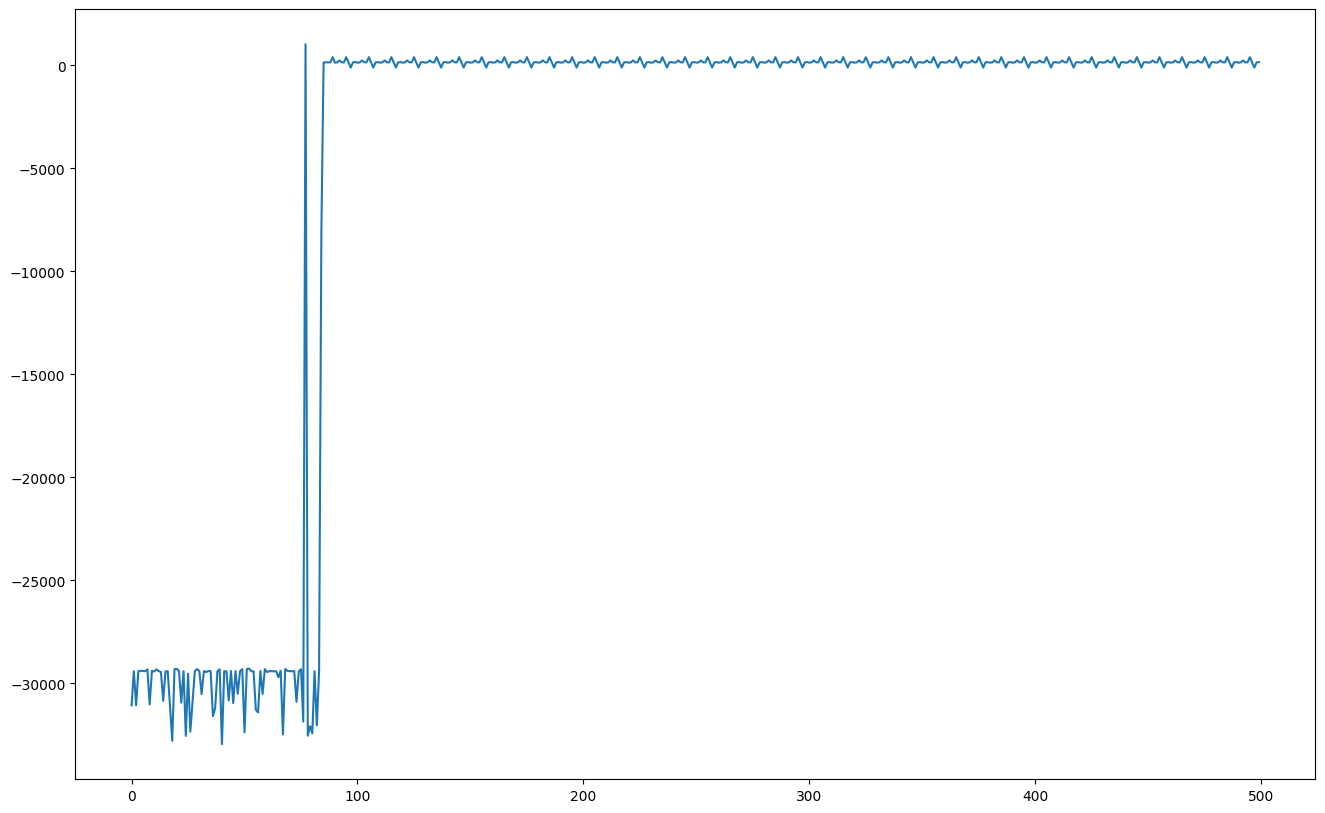

In [19]:
# from train import Trainer
from matplotlib import pyplot as plt
# import gym
from gym.envs.registration import register
gym.register(
    id='PointParticle-v0',
    entry_point=PointParticleEnv,   # or "__main__:PointParticleEnv"
    max_episode_steps=300    # ← choose a sensible episode length
)


env_name='PointParticle-v0'
trainer = Trainer(config_file=f'./configs/{env_name}.json',enable_logging=True)
episode_rewards, evaluations = trainer.train()

plt.figure(figsize=(16, 10))
plt.plot(episode_rewards)

#     ce0d0200dfea200450b86c341468e0ae12cf0570

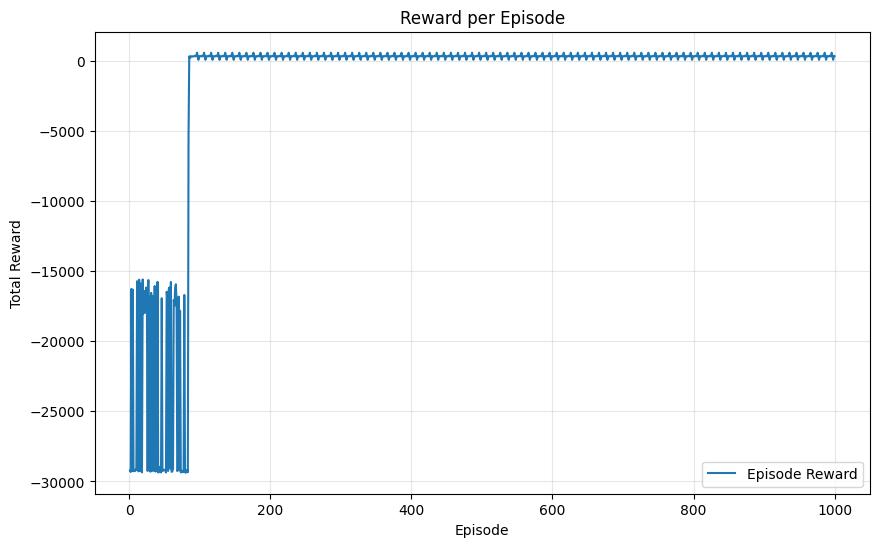

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1. Load data ----
# Adjust the path if your csv1.csv lives in a subfolder
df = pd.read_csv('csv1.csv')

# ---- 2. Extract series ----
episodes = df['episode'][:]
rewards = df['episode_reward']
goal_mask = df['goal_reached'] == 1

# ---- 3. Plot ----
plt.figure(figsize=(10, 6))
plt.plot(episodes, rewards, label='Episode Reward', linewidth=1.5)

# ---- 4. Decorations ----
plt.title('Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(alpha=0.3)

# ---- 5. Show or save ----
# To display interactively:
plt.show()



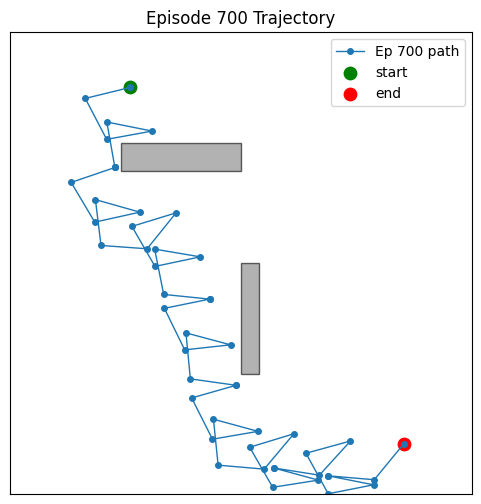

In [ ]:
from visualize import plot_episode_path
plot_episode_path('/content/drive/MyDrive/Projects/rl/DDPG-Pytorch/14_18_jun19/csv2.csv', episode_number=700)